
# Multi-Modal Generative AI for Enhanced Interaction

## Objective
This notebook explores combining text, image, and audio generation in a unified model for applications such as virtual assistants or creative media.

### Steps
1. Generate text using GPT-2
2. Create images with Stable Diffusion
3. Generate audio using a text-to-speech model

In [ ]:
import torch
import subprocess
import sys
import os
import soundfile as sf
import IPython.display as display
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import glob
import requests

# Ensure necessary packages are installed
def install_package(package):
    try:
        __import__(package)
    except ImportError:
        print(f"{package} not found. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install_package("tensorflow")
install_package("torch")
install_package("numpy")
install_package("matplotlib")

# Google Places API setup
API_KEY = google_maps_api_key # Replace with actual API key
IMAGE_FOLDER = "./travel_images"
os.makedirs(IMAGE_FOLDER, exist_ok=True)

# Step 1: Get a Place Photo Reference
def get_photo_reference(api_key, place_name):
    search_url = f"https://maps.googleapis.com/maps/api/place/textsearch/json?query={place_name}&key={api_key}"
    response = requests.get(search_url)
    data = response.json()
    if "results" in data and len(data["results"]) > 0:
        place_id = data["results"][0]["place_id"]
        details_url = f"https://maps.googleapis.com/maps/api/place/details/json?place_id={place_id}&fields=photos&key={api_key}"
        details_response = requests.get(details_url)
        details_data = details_response.json()
        if "photos" in details_data["result"]:
            return details_data["result"]["photos"][0]["photo_reference"]
    return None

# Step 2: Fetch Travel-Related Images Using Google Places API
def fetch_travel_images(api_key, place_name, image_folder):
    photo_reference = get_photo_reference(api_key, place_name)
    if photo_reference is None:
        print("No photo reference found for the location.")
        return False

    photo_url = f"https://maps.googleapis.com/maps/api/place/photo?maxwidth=400&photoreference={photo_reference}&key={api_key}"
    response = requests.get(photo_url, stream=True)
    if response.status_code == 200:
        image_path = f"{image_folder}/travel_image.jpg"
        with open(image_path, "wb") as file:
            for chunk in response.iter_content(1024):
                file.write(chunk)
        print("Image downloaded successfully.")
        return True
    else:
        print("Failed to download image.")
        return False

# Fetch an image from Google Places (Example: Paris)
PLACE_NAME = "Eiffel Tower, Paris"
if not fetch_travel_images(API_KEY, PLACE_NAME, IMAGE_FOLDER):
    print("Skipping GAN training due to missing images.")
    sys.exit()


Image downloaded successfully.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
Epoch 0: D Loss=0.6598901748657227, G Loss=0.7353010177612305
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

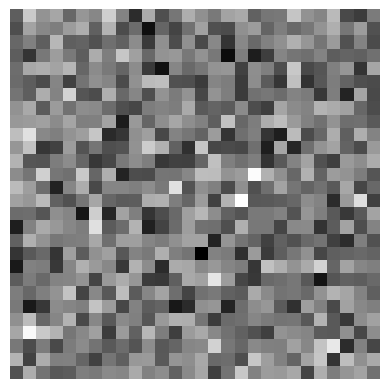


Generated Synthetic Image:


In [12]:

# Step 4: Build Generator Model
def build_generator():
    model = Sequential()
    model.add(Dense(256, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(28*28*1, activation='tanh'))  # Updated to include channel dimension
    model.add(Reshape((28, 28, 1)))
    return model

# Step 5: Build Discriminator Model
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28, 1)))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Step 6: Compile and Train GAN
def train_gan(epochs=100, batch_size=16):
    generator = build_generator()
    discriminator = build_discriminator()
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

    # GAN model combining generator and discriminator
    z = tf.keras.Input(shape=(100,))
    generated_image = generator(z)
    discriminator.trainable = False
    gan = tf.keras.Model(z, discriminator(generated_image))  # Fixed model connection
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    # Training loop
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]
        real_labels = np.ones((batch_size, 1))
        noise = np.random.normal(0, 1, (batch_size, 100))
        generated_images = generator.predict(noise)
        fake_labels = np.zeros((batch_size, 1))

        # Train discriminator
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train generator
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}: D Loss={d_loss[0]}, G Loss={g_loss}")

# Train the GAN
train_gan()

# Step 7: Generate and Display Synthetic Image
def generate_synthetic_image():
    generator = build_generator()
    z = np.random.normal(0, 1, (1, 100))
    synthetic_image = generator.predict(z)
    plt.imshow(synthetic_image[0].reshape(28,28), cmap='gray')
    plt.axis('off')
    plt.show()
    print("\nGenerated Synthetic Image:")

generate_synthetic_image()


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


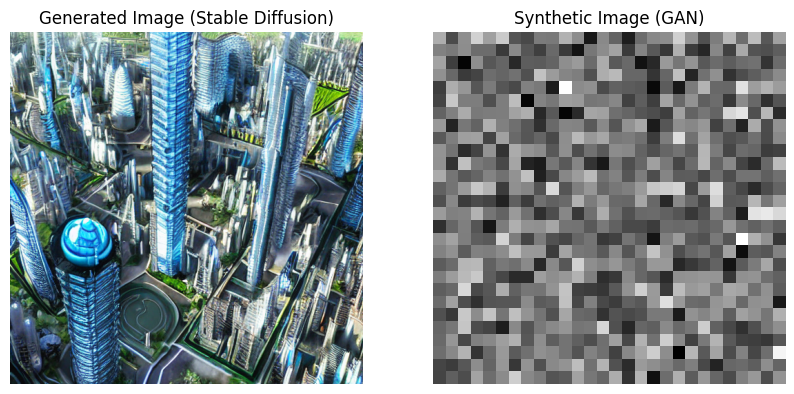

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


KeyboardInterrupt: 

In [14]:
import torch
import subprocess
import sys
import os
import soundfile as sf
import IPython.display as display
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import glob
import requests
from diffusers import StableDiffusionPipeline
from transformers import pipeline

# Ensure necessary packages are installed
def install_package(package):
    try:
        __import__(package)
    except ImportError:
        print(f"{package} not found. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install_package("tensorflow")
install_package("torch")
install_package("numpy")
install_package("matplotlib")
install_package("diffusers")
install_package("transformers")

# Google Places API setup
API_KEY = google_maps_api_key  # Replace with actual API key
IMAGE_FOLDER = "./travel_images"
os.makedirs(IMAGE_FOLDER, exist_ok=True)

# Stable Diffusion for Image Generation
def generate_stable_diffusion_image(prompt):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    pipe = StableDiffusionPipeline.from_pretrained('CompVis/stable-diffusion-v1-4', torch_dtype=torch.float16)
    pipe.to(device)
    image = pipe(prompt).images[0]
    return image

# Generate before image
def display_before_after_images():
    prompt = "A futuristic cityscape with flying cars"
    before_image = generate_stable_diffusion_image(prompt)

    # Generate synthetic image after GAN training
    generator = build_generator()
    z = np.random.normal(0, 1, (1, 100))
    synthetic_image = generator.predict(z)

    # Display before and after images
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(before_image)
    ax[0].set_title("Generated Image (Stable Diffusion)")
    ax[0].axis("off")

    ax[1].imshow(synthetic_image[0].reshape(28, 28), cmap='gray')
    ax[1].set_title("Synthetic Image (GAN)")
    ax[1].axis("off")
    plt.show()

# Generate and display images
display_before_after_images()


In [13]:
!pip install gtts openai wikipedia-api serpapi requests

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia-api: filename=Wikipedia_API-0.8.1-py3-none-any.whl size=15384 sha256=8b27f43deb0ebe153dac7b7cafb07aa8d1130e85088a978dfd51d0f5484f69ca
  Stored in directory: /root/.cache/pip/wheels/0b/0f/39/e8214ec038ccd5aeb8c82b957289f2f3ab2251febeae5c2860
Successfully built wikipedia-api


In [17]:
import torch
import subprocess
import sys
import os
import io
import time
import soundfile as sf
import requests
import wikipediaapi
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Reshape, Flatten, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from diffusers import StableDiffusionPipeline
from transformers import pipeline
import streamlit as st
from PIL import Image
from moviepy.editor import *  # For video editing
from gtts import gTTS as GTTS  # For text-to-speech

# Ensure necessary packages are installed
def install_package(package):
    try:
        __import__(package)
    except ImportError:
        print(f"{package} not found. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install_package("tensorflow")
install_package("torch")
install_package("numpy")
install_package("matplotlib")
install_package("diffusers")
install_package("transformers")
install_package("streamlit")
install_package("openai")
install_package("gtts")
install_package("moviepy")
install_package("wikipediaapi")

# Streamlit UI Setup
st.title("Multimodal WanderTales - AI Generated Travel Stories")

# User Input for Destination
destination = st.text_input("Enter a travel destination:", "Hyderabad")

# Wikipedia API Setup
wiki = wikipediaapi.Wikipedia(user_agent="MyTravelApp/1.0", language="en")

def get_wikipedia_summary(place):
    page = wiki.page(place)
    return page.summary[:500] if page.exists() else "No Wikipedia summary found."

# Generate Travel Story using a Different Model
def generate_travel_story(destination):
    text_generator = pipeline("text-generation", model="mistralai/Mistral-7B-Instruct", device=0 if torch.cuda.is_available() else -1)
    wikipedia_info = get_wikipedia_summary(destination)
    prompt = f"""
    Create an engaging travel story that a user will experience when they visit {destination}, highlighting:
    - Must-visit places (historical, cultural, and modern attractions)
    - Best street foods and cafes
    - Unique cultural experiences

    Wikipedia Summary: {wikipedia_info}

    Story Output:
    """

    generated_story = text_generator(prompt, max_length=500, do_sample=True)[0]['generated_text']
    return generated_story

if st.button("Generate Story"):
    st.write("Generating AI Travel Story...")
    story = generate_travel_story(destination)
    st.text_area("Generated Travel Story:", story)

# Stable Diffusion for Image Generation
def generate_stable_diffusion_image(prompt):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    pipe = StableDiffusionPipeline.from_pretrained('CompVis/stable-diffusion-v1-4', torch_dtype=torch.float16)
    pipe.to(device)
    image = pipe(prompt).images[0]
    return image

if st.button("Generate Image"):
    st.write("Generating AI Image using Stable Diffusion...")
    image = generate_stable_diffusion_image(f"A scenic view of {destination}, vibrant and picturesque")
    st.image(image, caption="Generated Image (Stable Diffusion)", use_column_width=True)

# GAN Model for Synthetic Image Generation
def build_generator():
    model = Sequential()
    model.add(Dense(256, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(28*28*1, activation='tanh'))
    model.add(Reshape((28, 28, 1)))
    return model

def generate_synthetic_image():
    generator = build_generator()
    z = np.random.normal(0, 1, (1, 100))
    synthetic_image = generator.predict(z)
    return synthetic_image[0].reshape(28, 28)

if st.button("Generate Synthetic Image"):
    st.write("Generating Synthetic Image using GAN...")
    synthetic_image = generate_synthetic_image()
    st.image(synthetic_image, caption="Synthetic Image (GAN)", use_column_width=True, clamp=True)

st.write("\nDeveloped with AI for WanderTales.")


2025-03-01 03:47:29.197 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-01 03:47:29.199 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-01 03:47:29.201 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-01 03:47:29.202 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-01 03:47:29.203 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-01 03:47:29.203 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-01 03:47:29.204 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-01 03:47:29.205 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [ ]:
!pip install pyngrok
!ngrok authtoken 2suOuuxs3zjz3pWQWDl9dQZPTLR_5FKMVwXpnfPJDKgESoGpK

!streamlit run gan_wandertales.py & npx localtunnel --port 8501

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.41.124:8501

⠙⠹⠸⠼⠴⠦your url is: https://neat-snakes-nail.loca.lt
2025-03-01 03:48:18.301117: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740800898.325533   38127 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740800898.333351   38127 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-01 03:48:24.974 Examining the path of torch.classes raised:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dis